In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import operator
import math
import warnings
import openpyxl
import random
warnings.filterwarnings('ignore')
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
import tensorflow as tf
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import pandas as pd

In [2]:
# 한글 글꼴체 변경
plt.rcParams['font.family'] ='Malgun Gothic'
# df.head() 이런거 했을 때, 컬럼이 생략되지 않고, 모든 컬럼 뜨게
pd.set_option('display.max_columns', None)
# 지수 표기법 대신에 소수점으로 표시하는코드
pd.options.display.float_format = '{:.2f}'.format
# 값 길이 제한 X
pd.set_option('display.max_colwidth', None) # 값 길이 제한 없음

## 로지스틱 회귀 진행
1. 랜덤 언더 샘플링 데이터
2. SMOTE-NC 데이터
3. SMOTE-NC + 랜덤 언더 샘플링 데이터
4. 가중치

모델링 과정은 기본 파라미터로 일단 진행됨.

### 1. 랜덤 언더 샘플링 데이터로 로지스틱 회귀 진행

#### 레이블 인코딩 + 정규화 + 이상치가 있는 컬럼에는 Robust 스케일링 진행

In [3]:
train = pd.read_csv("data/train/train_undersample_4_5.csv")
val = pd.read_csv("data/train/validation.csv")
test = pd.read_csv("data/train/test.csv")

In [21]:
display(train)
display(val)
display(test)

,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,CH_25_RATIO_1MONTH,churn
0,36개월 이상,HD,이코노미,N,Y,재약정,N,0건,0건,현장경로,10.00,약정만료전 12개월이상,2498,Y,N,N,6.00,일주일내,N,N,60대,수신,수신,1.49,기타,0.00,N,N,7.49,N
1,36개월 이상,HD,이코노미,N,Y,신규,N,0건,0건,현장경로,0.00,약정만료후 1개월~2개월,1127,N,N,N,2.00,일주일내,N,N,60대,전체거부,전체거부,2.18,기타,0.00,N,N,0.39,N
2,36개월 이상,HD,베이직,N,N,약정승계,N,0건,0건,일반상담,60.00,약정만료후 12개월이상,4521,N,N,N,1.00,일주일내,N,N,40대,전체거부,수신,9.94,KBS2,0.00,N,N,0.79,N
3,36개월 이상,HD,프리미엄,N,N,약정승계,N,0건,0건,현장경로,40.00,약정만료후 12개월이상,2519,Y,N,N,2.00,일주일내,N,N,60대,전체거부,수신,9.11,기타,0.00,N,N,1.90,N
4,36개월 이상,HD,이코노미,N,N,재약정,N,0건,0건,직영몰,40.00,약정만료전 12개월이상,1684,Y,N,N,3.00,일주일내,Y,N,40대,수신,수신,9.60,TV조선,0.00,N,N,4.12,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53089,36개월 이상,HD,베이직,N,N,약정승계,Y,0건,0건,I/B,0.00,약정만료후 12개월이상,2746,N,N,N,1.00,3개월내없음,N,N,60대,전체거부,전체거부,0.00,기타,0.00,N,N,0.00,Y
53090,36개월 이상,HD,베이직,N,N,약정승계,N,0건,0건,O/B,40.00,약정만료후 12개월이상,2428,N,N,N,2.00,일주일내,N,N,60대,전체거부,수신,6.07,기타,0.00,N,N,2.32,Y
53091,36개월 이상,HD,프리미엄,N,Y,재약정,N,0건,0건,I/B,0.00,약정만료전 12개월이상,3943,Y,N,N,4.00,3개월내없음,Y,N,70대,수신,수신,0.00,기타,0.00,N,N,0.00,Y
53092,36개월 이상,HD,프리미엄,N,N,약정승계,Y,0건,0건,O/B,0.00,약정만료후 12개월이상,3198,Y,N,N,3.00,3개월내없음,N,N,80대,수신,수신,0.00,기타,0.00,N,N,0.00,Y


,sha2_hash,p_mt,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,churn,CH_25_RATIO_1MONTH
0,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,6,24개월~ 36개월미만,HD,이코노미,N,Y,신규,N,0건,0건,I/B,0.00,약정만료전 6~9개월,20240325,855,Y,Y,N,3.00,일주일내,N,N,60대,수신,수신,4.03,기타,0.00,N,N,N,6.51
1,000015c9d6e36eac1e706b7495b536c36a7478897895f05e5b3b7f47a05fba34,6,24개월~ 36개월미만,HD,프리미엄,N,N,재약정,N,0건,0건,I/B,60.00,약정만료전 9~12개월,20240616,4249,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,18.08,기타,0.00,N,N,N,0.06
2,0000161608bc85042f2a7b2d51524e01e44da09a2c92ed7136f09c3b90414858,6,36개월 이상,HD,베이직,N,Y,재약정,N,0건,0건,일반상담,10.00,약정만료전 12개월이상,20250718,2488,Y,N,N,6.00,일주일내,N,N,60대,수신,수신,1.09,기타,0.00,N,N,N,6.85
3,00001c363e8c833646a913c7566acd329523316f6a03afc0fe77dac7ca828d17,6,36개월 이상,HD,이코노미,N,Y,신규,N,0건,0건,일반상담,10.00,약정만료후 3~6개월,20230127,1836,N,N,N,3.00,일주일내,N,N,60대,수신,수신,1.32,TV조선,0.00,N,N,N,13.55
4,00001f885d4d6c5ff6d01d5ebf1d6093d7f53c130de5fa3652dc0424d165b21c,6,36개월 이상,HD,프리미엄,N,Y,신규,N,1건,1건,현장경로,0.00,약정만료후 12개월이상,20190828,3826,Y,N,N,4.00,일주일내,N,N,50대,수신,수신,1.27,기타,0.00,N,N,N,7.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1955113,ffffdac172fec24c59aea00b7c6e53b8f9631e323cb99ada41a5fc7c38eaa74c,6,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,현장경로,0.00,약정만료후 12개월이상,20191114,3446,N,N,N,2.00,2주일전,N,N,50대,수신,수신,1.72,기타,0.00,N,N,N,0.23
1955114,ffffe2ae4b1bafe83133c187e7628932d4915bc7ee92457ac4b1b61e5362c3ba,6,36개월 이상,HD,이코노미,N,N,신규,N,1건,0건,O/B,10.00,약정만료후 12개월이상,20200831,2128,Y,N,N,3.00,일주일내,N,N,40대,전체거부,전체거부,2.12,기타,0.00,N,N,N,0.00
1955115,ffffe9bc336450ed573a845cea2376c7dc913ba9d775e3223931ed33ba2f08f0,6,12개월~24개월미만,HD,이코노미,N,N,약정승계,N,0건,0건,일반상담,0.00,약정만료후 12개월이상,20141014,3805,N,N,N,2.00,일주일내,N,N,30대,수신,수신,0.73,TV조선,0.00,N,N,N,0.00
1955116,ffffeb35773f914285afa493a7b7cf236063af847c72f39cab28d078edfc74df,6,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,20.00,약정만료전 12개월이상,20250614,1399,Y,N,N,2.00,일주일내,Y,N,50대,수신,수신,4.37,KBS1,0.00,N,N,N,1.28


,sha2_hash,p_mt,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,churn,CH_25_RATIO_1MONTH
0,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,11,24개월~ 36개월미만,HD,이코노미,N,Y,재약정,N,0건,0건,I/B,20.00,약정만료전 12개월이상,20260820,1008,Y,Y,N,3.00,일주일내,N,N,60대,수신,수신,6.23,기타,0.00,N,N,N,4.72
1,000015c9d6e36eac1e706b7495b536c36a7478897895f05e5b3b7f47a05fba34,11,24개월~ 36개월미만,HD,프리미엄,N,N,재약정,N,0건,0건,I/B,70.00,약정만료전 6~9개월,20240616,4402,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,15.37,기타,1.00,N,N,N,0.48
2,0000161608bc85042f2a7b2d51524e01e44da09a2c92ed7136f09c3b90414858,11,36개월 이상,HD,베이직,N,Y,재약정,N,0건,0건,일반상담,10.00,약정만료전 12개월이상,20250718,2641,Y,N,N,6.00,일주일내,N,N,60대,수신,수신,1.47,기타,1.00,N,N,N,2.97
3,00001c363e8c833646a913c7566acd329523316f6a03afc0fe77dac7ca828d17,11,36개월 이상,HD,이코노미,N,Y,신규,N,0건,0건,일반상담,10.00,약정만료후 9~12개월,20230127,1989,N,N,N,3.00,일주일내,N,N,60대,수신,수신,2.16,기타,0.00,N,N,N,11.85
4,00001f885d4d6c5ff6d01d5ebf1d6093d7f53c130de5fa3652dc0424d165b21c,11,36개월 이상,HD,프리미엄,N,Y,신규,N,1건,1건,현장경로,0.00,약정만료후 12개월이상,20190828,3979,Y,N,N,4.00,일주일내,Y,N,50대,수신,수신,1.64,기타,0.00,N,N,N,2.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945590,ffffdac172fec24c59aea00b7c6e53b8f9631e323cb99ada41a5fc7c38eaa74c,11,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,현장경로,0.00,약정만료후 12개월이상,20191114,3599,N,N,N,2.00,3개월내없음,N,N,50대,수신,수신,0.00,기타,0.00,N,N,N,0.00
1945591,ffffe2ae4b1bafe83133c187e7628932d4915bc7ee92457ac4b1b61e5362c3ba,11,36개월 이상,HD,이코노미,N,N,신규,N,1건,0건,O/B,10.00,약정만료후 12개월이상,20200831,2281,Y,N,N,3.00,일주일내,N,N,40대,전체거부,전체거부,1.81,MBN,0.00,N,N,N,4.40
1945592,ffffe9bc336450ed573a845cea2376c7dc913ba9d775e3223931ed33ba2f08f0,11,12개월~24개월미만,HD,이코노미,N,N,약정승계,N,0건,0건,일반상담,0.00,약정만료후 12개월이상,20141014,3958,N,N,N,2.00,일주일내,N,N,30대,수신,수신,1.69,기타,0.00,N,N,N,0.00
1945593,ffffeb35773f914285afa493a7b7cf236063af847c72f39cab28d078edfc74df,11,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,20.00,약정만료전 12개월이상,20250614,1552,Y,N,N,2.00,일주일내,N,N,50대,수신,수신,3.39,기타,0.00,N,N,N,2.42


In [4]:
# INHOME_RATE 컬럼은 object로

train['INHOME_RATE'] = train['INHOME_RATE'].astype(str)
val['INHOME_RATE'] = val['INHOME_RATE'].astype(str)
test['INHOME_RATE'] = test['INHOME_RATE'].astype(str)
print(train['INHOME_RATE'].dtypes)
print(val['INHOME_RATE'].dtypes)
print(test['INHOME_RATE'].dtypes)

object
object
object


In [5]:
# train = train.drop(columns=['sha2_hash','p_mt','AGMT_END_YMD'])
val = val.drop(columns=['sha2_hash','p_mt','AGMT_END_YMD'])
test = test.drop(columns=['sha2_hash','p_mt','AGMT_END_YMD'])

레이블 인코딩 진행

In [7]:
categorical_cols = train.select_dtypes(include=['object']).columns

# Train에는 없고 Validation에만 있는 값 찾기
unseen_values = {}

for col in categorical_cols:
    train_unique = set(train[col].unique())
    val_unique = set(val[col].unique())

    unseen = val_unique - train_unique
    if unseen:
        unseen_values[col] = unseen

# 결과 출력
print(unseen_values)


{'PROD_NM_GRP': {'기타'}, 'AGMT_KIND_NM': {'정보없음'}, 'INHOME_RATE': {'100.0'}, 'AGMT_END_SEG': {'기타'}}


In [8]:
val = val[val['PROD_NM_GRP'] != '기타'].reset_index(drop=True)
test = test[test['PROD_NM_GRP'] != '기타'].reset_index(drop=True)

val = val[val['AGMT_KIND_NM'] != '정보없음'].reset_index(drop=True)
test = test[test['AGMT_KIND_NM'] != '정보없음'].reset_index(drop=True)

val = val[val['INHOME_RATE'] != '100.0'].reset_index(drop=True)
test = test[test['INHOME_RATE'] != '100.0'].reset_index(drop=True)

val = val[val['AGMT_END_SEG'] != '기타'].reset_index(drop=True)
test = test[test['AGMT_END_SEG'] != '기타'].reset_index(drop=True)


In [9]:
# 레이블 인코딩 진행!

from sklearn.preprocessing import LabelEncoder

categorical_cols = train.select_dtypes(include=['object']).columns

# 레이블 인코딩 수행
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    val[col] = le.transform(val[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

print("레이블 인코딩 끝")

레이블 인코딩 끝


In [28]:
display(train)
display(val)
display(test)

,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,CH_25_RATIO_1MONTH,churn
0,2,0,3,0,1,5,0,0,0,9,1,1,2498,1,0,0,6.00,4,0,0,5,2,2,1.49,12,0.00,0,0,7.49,0
1,2,0,3,0,1,0,0,0,0,9,0,9,1127,0,0,0,2.00,4,0,0,5,3,3,2.18,12,0.00,0,0,0.39,0
2,2,0,0,0,0,2,0,0,0,4,6,8,4521,0,0,0,1.00,4,0,0,3,3,2,9.94,3,0.00,0,0,0.79,0
3,2,0,4,0,0,2,0,0,0,9,4,8,2519,1,0,0,2.00,4,0,0,5,3,2,9.11,12,0.00,0,0,1.90,0
4,2,0,3,0,0,5,0,0,0,8,4,1,1684,1,0,0,3.00,4,1,0,3,2,2,9.60,8,0.00,0,0,4.12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53089,2,0,0,0,0,2,1,0,0,0,0,8,2746,0,0,0,1.00,1,0,0,5,3,3,0.00,12,0.00,0,0,0.00,1
53090,2,0,0,0,0,2,0,0,0,1,4,8,2428,0,0,0,2.00,4,0,0,5,3,2,6.07,12,0.00,0,0,2.32,1
53091,2,0,4,0,1,5,0,0,0,0,0,1,3943,1,0,0,4.00,1,1,0,6,2,2,0.00,12,0.00,0,0,0.00,1
53092,2,0,4,0,0,2,1,0,0,1,0,8,3198,1,0,0,3.00,1,0,0,7,2,2,0.00,12,0.00,0,0,0.00,1


,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,churn,CH_25_RATIO_1MONTH
0,1,0,3,0,1,0,0,0,0,0,0,6,855,1,1,0,3.00,4,0,0,5,2,2,4.03,12,0.00,0,0,0,6.51
1,1,0,4,0,0,5,0,0,0,0,6,7,4249,1,1,0,2.00,4,0,0,4,2,2,18.08,12,0.00,0,0,0,0.06
2,2,0,0,0,1,5,0,0,0,4,1,1,2488,1,0,0,6.00,4,0,0,5,2,2,1.09,12,0.00,0,0,0,6.85
3,2,0,3,0,1,0,0,0,0,4,1,11,1836,0,0,0,3.00,4,0,0,5,2,2,1.32,8,0.00,0,0,0,13.55
4,2,0,4,0,1,0,0,1,1,9,0,8,3826,1,0,0,4.00,4,0,0,4,2,2,1.27,12,0.00,0,0,0,7.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1955096,2,0,0,0,0,5,0,0,0,9,0,8,3446,0,0,0,2.00,0,0,0,4,2,2,1.72,12,0.00,0,0,0,0.23
1955097,2,0,3,0,0,0,0,1,0,1,1,8,2128,1,0,0,3.00,4,0,0,3,3,3,2.12,12,0.00,0,0,0,0.00
1955098,0,0,3,0,0,2,0,0,0,4,0,8,3805,0,0,0,2.00,4,0,0,2,2,2,0.73,8,0.00,0,0,0,0.00
1955099,2,1,0,0,0,5,0,0,0,0,2,1,1399,1,0,0,2.00,4,1,0,4,2,2,4.37,2,0.00,0,0,0,1.28


,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,churn,CH_25_RATIO_1MONTH
0,1,0,3,0,1,5,0,0,0,0,2,1,1008,1,1,0,3.00,4,0,0,5,2,2,6.23,12,0.00,0,0,0,4.72
1,1,0,4,0,0,5,0,0,0,0,7,6,4402,1,1,0,2.00,4,0,0,4,2,2,15.37,12,1.00,0,0,0,0.48
2,2,0,0,0,1,5,0,0,0,4,1,1,2641,1,0,0,6.00,4,0,0,5,2,2,1.47,12,1.00,0,0,0,2.97
3,2,0,3,0,1,0,0,0,0,4,1,13,1989,0,0,0,3.00,4,0,0,5,2,2,2.16,12,0.00,0,0,0,11.85
4,2,0,4,0,1,0,0,1,1,9,0,8,3979,1,0,0,4.00,4,1,0,4,2,2,1.64,12,0.00,0,0,0,2.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945579,2,0,0,0,0,5,0,0,0,9,0,8,3599,0,0,0,2.00,1,0,0,4,2,2,0.00,12,0.00,0,0,0,0.00
1945580,2,0,3,0,0,0,0,1,0,1,1,8,2281,1,0,0,3.00,4,0,0,3,3,3,1.81,5,0.00,0,0,0,4.40
1945581,0,0,3,0,0,2,0,0,0,4,0,8,3958,0,0,0,2.00,4,0,0,2,2,2,1.69,12,0.00,0,0,0,0.00
1945582,2,1,0,0,0,5,0,0,0,0,2,1,1552,1,0,0,2.00,4,0,0,4,2,2,3.39,12,0.00,0,0,0,2.42


Robust 스케일링 할 컬럼 설정
- TOTAL_USED_DAYS
- CH_HH_AVG_MONTH1
- KIDS_USE_PV_MONTH1
- CH_25_RATIO_1MONTH

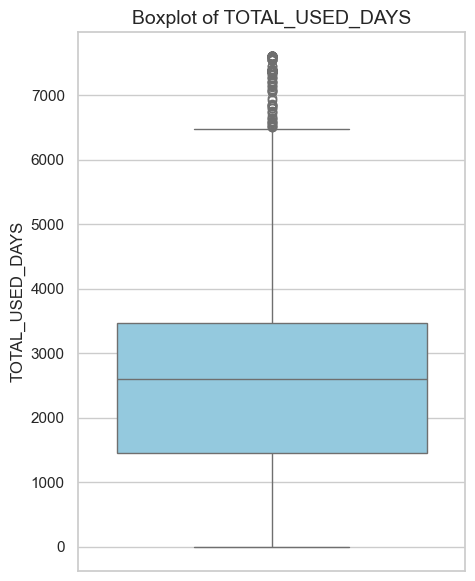

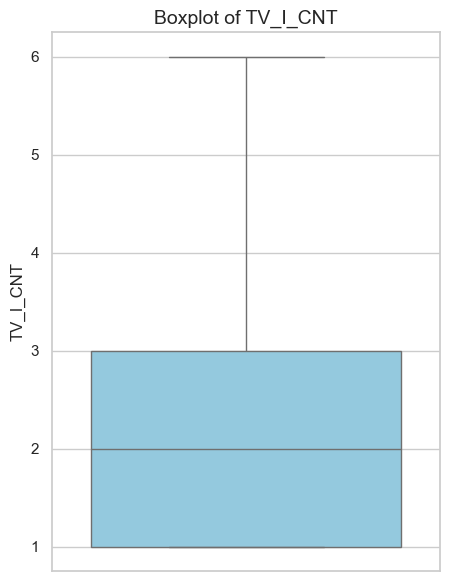

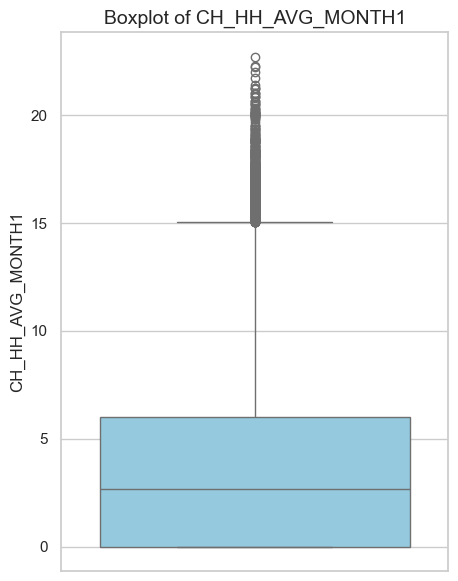

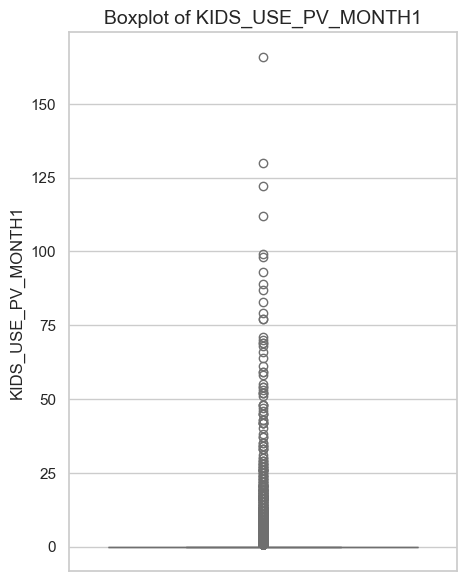

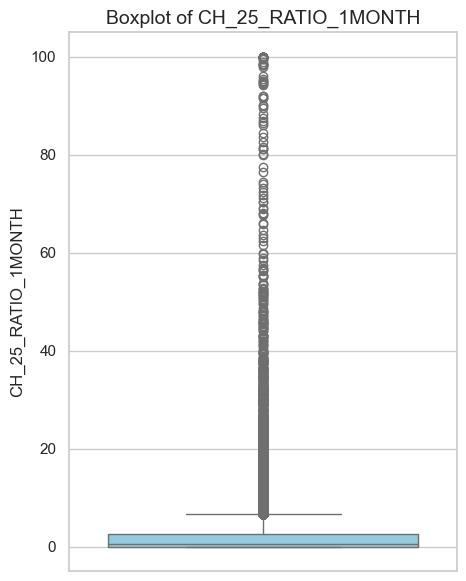

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# df에서 연속형(수치형) 변수 찾기
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Seaborn 스타일 적용
sns.set(style="whitegrid")

# 각 연속형 변수에 대해 boxplot 생성 (세로 방향)
for col in numeric_columns:
    plt.figure(figsize=(5, 7))  # 세로로 길게 설정
    sns.boxplot(y=train[col], color="skyblue")  # 세로 방향 boxplot

    # 제목 및 라벨 추가
    plt.ylabel(col, fontsize=12)
    plt.title(f'Boxplot of {col}', fontsize=14)

    # 그래프 표시
    plt.show()


In [10]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# 내가 정한 robust 스케일링 컬럼들
robust_columns = ['TOTAL_USED_DAYS', 'CH_HH_AVG_MONTH1', 'KIDS_USE_PV_MONTH1', 'CH_25_RATIO_1MONTH']  # RobustScaler를 적용할 컬럼
minmax_columns = [col for col in train.columns if col not in robust_columns + ['churn']]  # 나머지 컬럼

# 스케일러 생성
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# RobustScaler 적용
train[robust_columns] = robust_scaler.fit_transform(train[robust_columns])
val[robust_columns] = robust_scaler.transform(val[robust_columns])
test[robust_columns] = robust_scaler.transform(test[robust_columns])

# MinMaxScaler 적용
train[minmax_columns] = minmax_scaler.fit_transform(train[minmax_columns])
val[minmax_columns] = minmax_scaler.transform(val[minmax_columns])
test[minmax_columns] = minmax_scaler.transform(test[minmax_columns])

# 결과 확인
print("robust, minmax 끝")


robust, minmax 끝


In [31]:
train.to_csv("data/train/randomunder_modeling/train.csv", index=False)
val.to_csv("data/train/randomunder_modeling/val.csv", index=False)
test.to_csv("data/train/randomunder_modeling/test.csv", index=False)

In [11]:
# 로지스틱 회귀 모델 진행

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train = train.drop(columns=['churn'])
y_train = train['churn']

# 로지스틱 회귀 모델 생성
#
model = LogisticRegression(solver='liblinear', random_state=42)

# 모델 학습
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

Validation Accuracy: 0.76

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.76      0.86   1941849
           1       0.02      0.68      0.04     13252

    accuracy                           0.76   1955101
   macro avg       0.51      0.72      0.45   1955101
weighted avg       0.99      0.76      0.86   1955101


Confusion Matrix (Validation):
[[1479287  462562]
 [   4240    9012]]


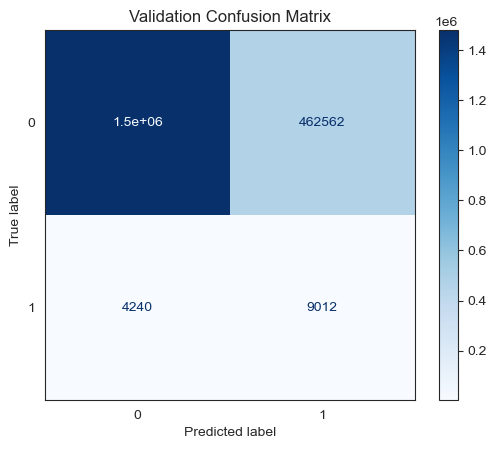

Validation AUC-ROC: 0.80


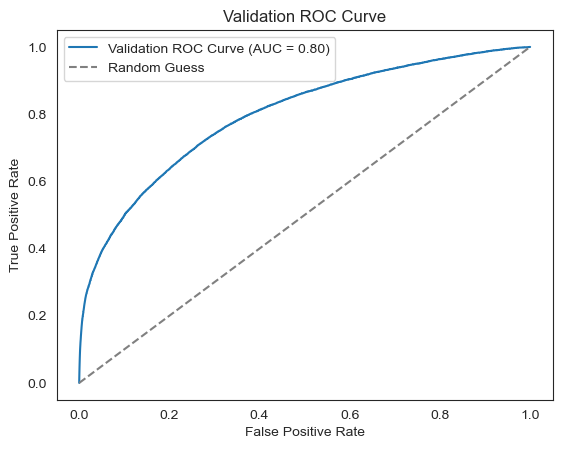

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
print(confusion_matrix(y_val, val_predictions))
disp_val = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, val_predictions), display_labels=model.classes_)

# Confusion Matrix
plt.figure()
disp_val.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Validation Confusion Matrix")
plt.show()

# AUC-ROC 계산 및 시각화
val_probabilities = model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(False)
plt.show()


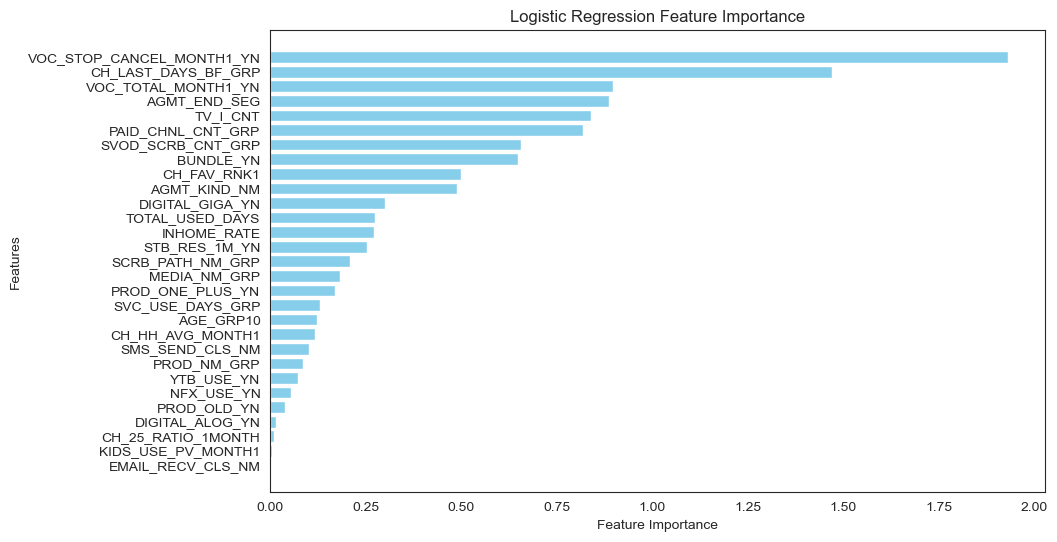

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Feature Importance 추출 (절댓값 사용)
feature_importance = np.abs(model.coef_[0])

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Logistic Regression Feature Importance")
plt.gca().invert_yaxis()
plt.show()


---

### 2. SMOTE-NC 데이터로 로지스틱 회귀 진행

#### 레이블 인코딩 + 정규화 + 이상치가 있는 컬럼에는 Robust 스케일링 진행

In [14]:
train = pd.read_csv("data/train/train_smotenc_4_5.csv")
val = pd.read_csv("data/train/validation.csv")
test = pd.read_csv("data/train/test.csv")

In [15]:
train = train.drop(columns=['KIDS_USE_YN'])
val = val.drop(columns=['sha2_hash','p_mt','AGMT_END_YMD'])
test = test.drop(columns=['sha2_hash','p_mt','AGMT_END_YMD'])

In [16]:
# INHOME_RATE 컬럼은 object로

train['INHOME_RATE'] = train['INHOME_RATE'].astype(str)
val['INHOME_RATE'] = val['INHOME_RATE'].astype(str)
test['INHOME_RATE'] = test['INHOME_RATE'].astype(str)
print(train['INHOME_RATE'].dtypes)
print(val['INHOME_RATE'].dtypes)
print(test['INHOME_RATE'].dtypes)

object
object
object


레이블 인코딩 진행

In [17]:
# 레이블 인코딩 진행!

from sklearn.preprocessing import LabelEncoder

categorical_cols = train.select_dtypes(include=['object']).columns

# 레이블 인코딩 수행
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    val[col] = le.transform(val[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

print("레이블 인코딩 끝")

레이블 인코딩 끝


In [18]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# 내가 정한 robust 스케일링 컬럼들
robust_columns = ['TOTAL_USED_DAYS', 'CH_HH_AVG_MONTH1', 'KIDS_USE_PV_MONTH1', 'CH_25_RATIO_1MONTH']  # RobustScaler를 적용할 컬럼
minmax_columns = [col for col in train.columns if col not in robust_columns + ['churn']]  # 나머지 컬럼

# 스케일러 생성
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# RobustScaler 적용
train[robust_columns] = robust_scaler.fit_transform(train[robust_columns])
val[robust_columns] = robust_scaler.transform(val[robust_columns])
test[robust_columns] = robust_scaler.transform(test[robust_columns])

# MinMaxScaler 적용
train[minmax_columns] = minmax_scaler.fit_transform(train[minmax_columns])
val[minmax_columns] = minmax_scaler.transform(val[minmax_columns])
test[minmax_columns] = minmax_scaler.transform(test[minmax_columns])

# 결과 확인
print("robust, minmax 끝")

robust, minmax 끝


In [9]:
train.to_csv("data/train/smote_modeling/train.csv", index=False)
val.to_csv("data/train/smote_modeling/val.csv", index=False)
test.to_csv("data/train/smote_modeling/test.csv", index=False)

In [19]:
# 로지스틱 회귀 모델 진행

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train = train.drop(columns=['churn'])
y_train = train['churn']

# 로지스틱 회귀 모델 생성
#
model = LogisticRegression(solver='liblinear', random_state=42)

# 모델 학습
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

Validation Accuracy: 0.74

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.74      0.85   1941866
           1       0.02      0.59      0.03     13252

    accuracy                           0.74   1955118
   macro avg       0.51      0.67      0.44   1955118
weighted avg       0.99      0.74      0.85   1955118


Confusion Matrix (Validation):
[[1443174  498692]
 [   5395    7857]]


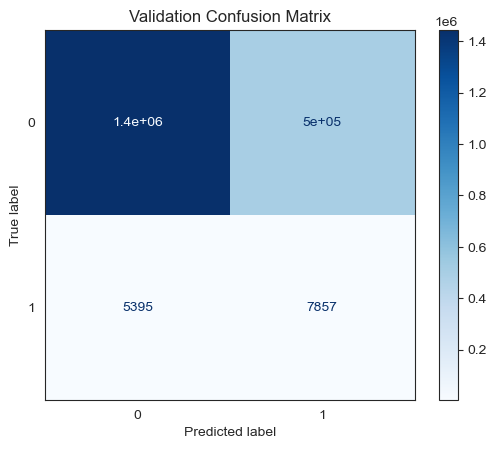

Validation AUC-ROC: 0.72


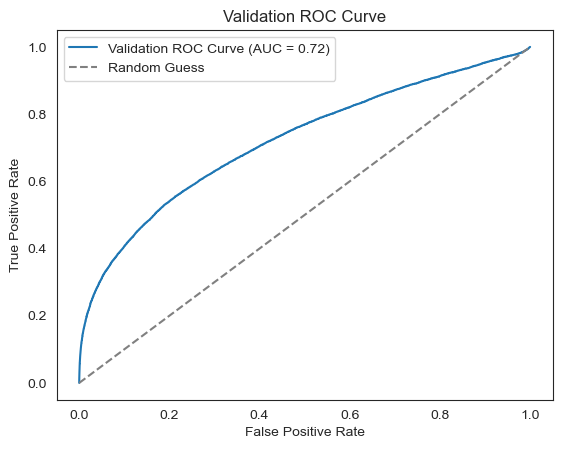

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
print(confusion_matrix(y_val, val_predictions))
disp_val = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, val_predictions), display_labels=model.classes_)

# Confusion Matrix
plt.figure()
disp_val.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Validation Confusion Matrix")
plt.show()

# AUC-ROC 계산 및 시각화
val_probabilities = model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(False)
plt.show()


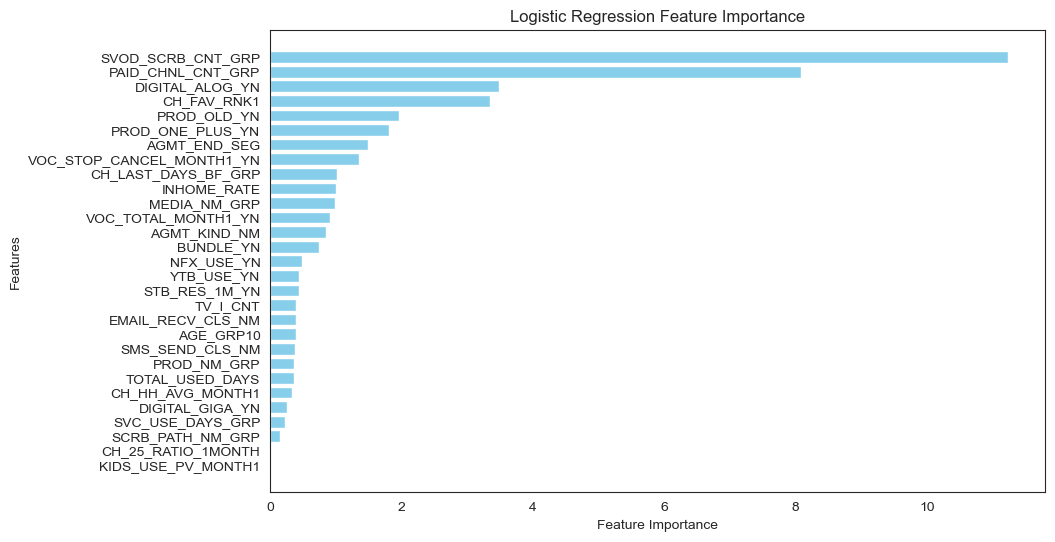

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

feature_importance = np.abs(model.coef_[0])

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Logistic Regression Feature Importance")
plt.gca().invert_yaxis()
plt.show()

---

### 3. SMOTE-NC + 랜덤 언더 샘플링 데이터로 로지스틱 회귀 진행

#### 레이블 인코딩 + 정규화 + 이상치가 있는 컬럼에는 Robust 스케일링 진행

In [22]:
train = pd.read_csv("data/train/train_randomunder_smotenc_4_5.csv")
val = pd.read_csv("data/train/validation.csv")
test = pd.read_csv("data/train/test.csv")

In [23]:
train = train.drop(columns=['KIDS_USE_YN'])
val = val.drop(columns=['sha2_hash','p_mt','AGMT_END_YMD'])
test = test.drop(columns=['sha2_hash','p_mt','AGMT_END_YMD'])

In [24]:
# INHOME_RATE 컬럼은 object로

train['INHOME_RATE'] = train['INHOME_RATE'].astype(str)
val['INHOME_RATE'] = val['INHOME_RATE'].astype(str)
test['INHOME_RATE'] = test['INHOME_RATE'].astype(str)
print(train['INHOME_RATE'].dtypes)
print(val['INHOME_RATE'].dtypes)
print(test['INHOME_RATE'].dtypes)

object
object
object


레이블 인코딩 진행

In [25]:
# 레이블 인코딩 진행!

from sklearn.preprocessing import LabelEncoder

categorical_cols = train.select_dtypes(include=['object']).columns

# 레이블 인코딩 수행
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    val[col] = le.transform(val[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

print("레이블 인코딩 끝")

레이블 인코딩 끝


In [26]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# 내가 정한 robust 스케일링 컬럼들
robust_columns = ['TOTAL_USED_DAYS', 'CH_HH_AVG_MONTH1', 'KIDS_USE_PV_MONTH1', 'CH_25_RATIO_1MONTH']  # RobustScaler를 적용할 컬럼
minmax_columns = [col for col in train.columns if col not in robust_columns + ['churn']]  # 나머지 컬럼

# 스케일러 생성
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# RobustScaler 적용
train[robust_columns] = robust_scaler.fit_transform(train[robust_columns])
val[robust_columns] = robust_scaler.transform(val[robust_columns])
test[robust_columns] = robust_scaler.transform(test[robust_columns])

# MinMaxScaler 적용
train[minmax_columns] = minmax_scaler.fit_transform(train[minmax_columns])
val[minmax_columns] = minmax_scaler.transform(val[minmax_columns])
test[minmax_columns] = minmax_scaler.transform(test[minmax_columns])

# 결과 확인
print("robust, minmax 끝")

robust, minmax 끝


In [20]:
train.to_csv("data/train/smoterandom_modeling/train.csv", index=False)
val.to_csv("data/train/smoterandom_modeling/val.csv", index=False)
test.to_csv("data/train/smoterandom_modeling/test.csv", index=False)

In [27]:
# 로지스틱 회귀 모델 진행

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train = train.drop(columns=['churn'])
y_train = train['churn']

# 로지스틱 회귀 모델 생성
model = LogisticRegression(solver='liblinear', random_state=42)

# 모델 학습
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

Validation Accuracy: 0.79

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.79      0.88   1941866
           1       0.02      0.55      0.03     13252

    accuracy                           0.79   1955118
   macro avg       0.51      0.67      0.46   1955118
weighted avg       0.99      0.79      0.88   1955118


Confusion Matrix (Validation):
[[1537846  404020]
 [   5945    7307]]


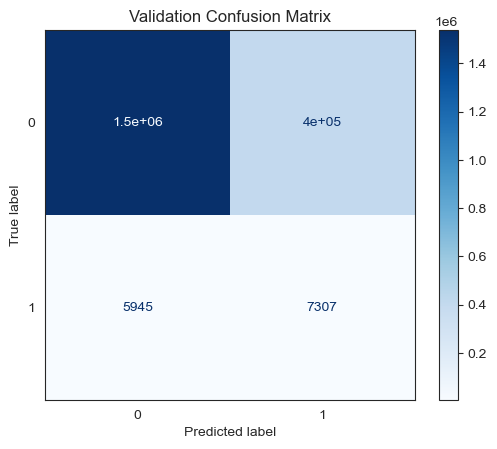

Validation AUC-ROC: 0.72


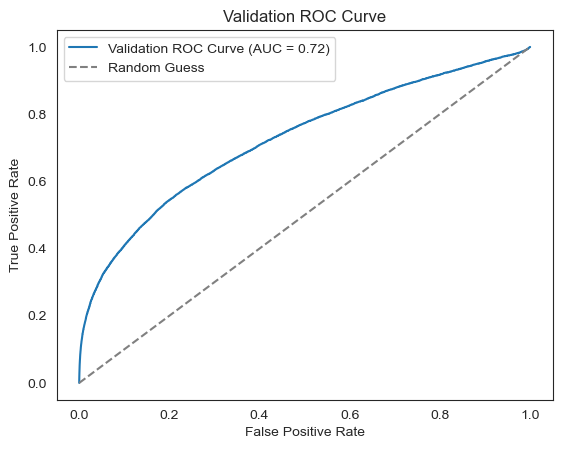

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
print(confusion_matrix(y_val, val_predictions))
disp_val = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, val_predictions), display_labels=model.classes_)

# Confusion Matrix
plt.figure()
disp_val.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Validation Confusion Matrix")
plt.show()

# AUC-ROC 계산 및 시각화
val_probabilities = model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(False)
plt.show()


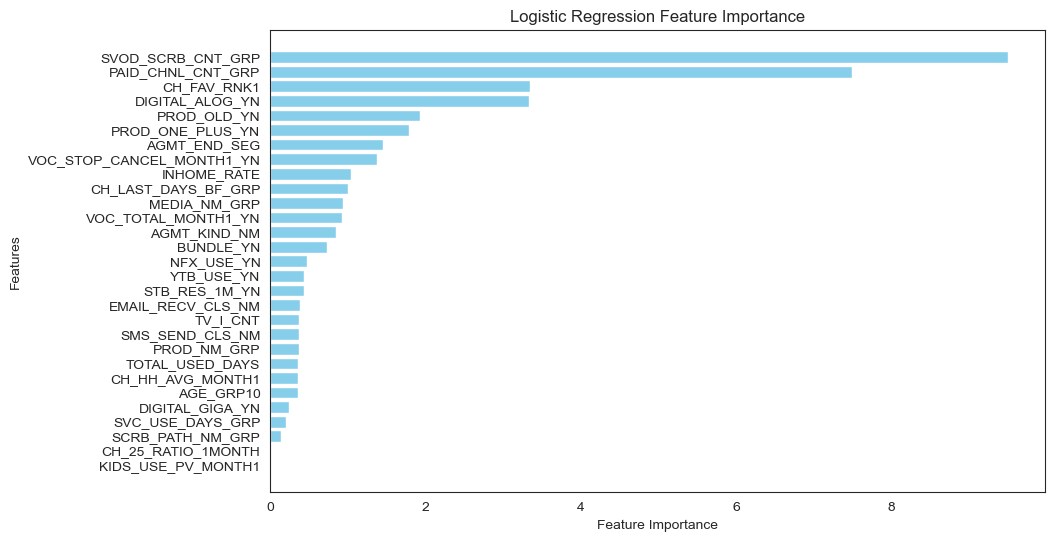

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

feature_importance = np.abs(model.coef_[0])

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Logistic Regression Feature Importance")
plt.gca().invert_yaxis()
plt.show()

---

### 4. 가중치로 로지스틱 회귀 진행

#### 레이블 인코딩 + 정규화 + 이상치가 있는 컬럼에는 Robust 스케일링 진행

In [30]:
# train은 4,5월 데이터

train = pd.read_csv("data/train/train.csv")
val = pd.read_csv("data/train/validation.csv")
test = pd.read_csv("data/train/test.csv")

In [31]:
val = val.drop(columns=['sha2_hash','p_mt','AGMT_END_YMD'])
test = test.drop(columns=['sha2_hash','p_mt','AGMT_END_YMD'])

In [32]:
# INHOME_RATE 컬럼은 object로

train['INHOME_RATE'] = train['INHOME_RATE'].astype(str)
val['INHOME_RATE'] = val['INHOME_RATE'].astype(str)
test['INHOME_RATE'] = test['INHOME_RATE'].astype(str)
print(train['INHOME_RATE'].dtypes)
print(val['INHOME_RATE'].dtypes)
print(test['INHOME_RATE'].dtypes)

object
object
object


In [33]:
# 레이블 인코딩 진행!

from sklearn.preprocessing import LabelEncoder

categorical_cols = train.select_dtypes(include=['object']).columns

# 레이블 인코딩 수행
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    val[col] = le.transform(val[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

print("레이블 인코딩 끝")

레이블 인코딩 끝


In [34]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# 내가 정한 robust 스케일링 컬럼들
robust_columns = ['TOTAL_USED_DAYS', 'CH_HH_AVG_MONTH1', 'KIDS_USE_PV_MONTH1', 'CH_25_RATIO_1MONTH']  # RobustScaler를 적용할 컬럼
minmax_columns = [col for col in train.columns if col not in robust_columns + ['churn']]  # 나머지 컬럼

# 스케일러 생성
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# RobustScaler 적용
train[robust_columns] = robust_scaler.fit_transform(train[robust_columns])
val[robust_columns] = robust_scaler.transform(val[robust_columns])
test[robust_columns] = robust_scaler.transform(test[robust_columns])

# MinMaxScaler 적용
train[minmax_columns] = minmax_scaler.fit_transform(train[minmax_columns])
val[minmax_columns] = minmax_scaler.transform(val[minmax_columns])
test[minmax_columns] = minmax_scaler.transform(test[minmax_columns])

# 결과 확인
print("robust, minmax 끝")

robust, minmax 끝


In [35]:
# 로지스틱 회귀 모델 진행

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train = train.drop(columns=['churn'])
y_train = train['churn']

# 로지스틱 회귀 모델 생성
model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)

# 모델 학습
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

Validation Accuracy: 0.76

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.76      0.86   1941866
           1       0.02      0.69      0.04     13252

    accuracy                           0.76   1955118
   macro avg       0.51      0.72      0.45   1955118
weighted avg       0.99      0.76      0.86   1955118


Confusion Matrix (Validation):
[[1471765  470101]
 [   4159    9093]]


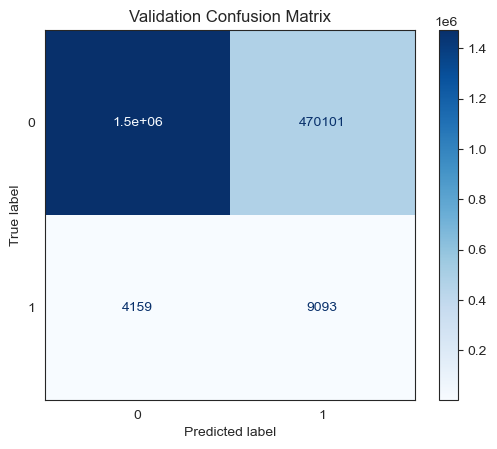

Validation AUC-ROC: 0.80


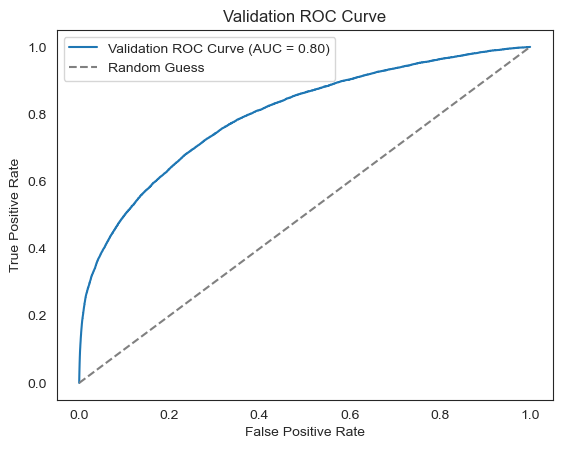

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
print(confusion_matrix(y_val, val_predictions))
disp_val = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, val_predictions), display_labels=model.classes_)

# Confusion Matrix
plt.figure()
disp_val.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Validation Confusion Matrix")
plt.show()

# AUC-ROC 계산 및 시각화
val_probabilities = model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(False)
plt.show()


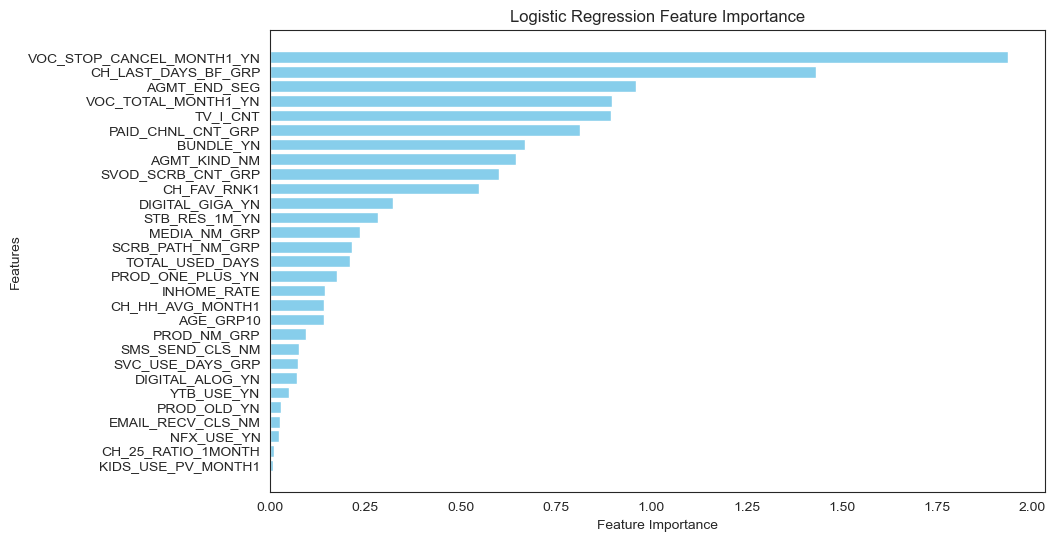

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

feature_importance = np.abs(model.coef_[0])

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Logistic Regression Feature Importance")
plt.gca().invert_yaxis()
plt.show()

---

#### 결론
로지스틱 회귀는 랜덤 언더 또는 가중치를 했을 때, 가장 좋다

### 📌 로지스틱 회귀 성능 비교 (Sampling 기법별)

| 샘플링 기법             | Accuracy | 1의 Recall | ROC-AUC |
|------------------------|----------|-----------|---------|
| <span style="color:red;">**랜덤 언더샘플링**</span>     | 0.76     | 0.68      | 0.80    |
| **SMOTE**              | 0.74     | 0.59      | 0.72    |
| **SMOTE + 랜덤 언더샘플링** | 0.79     | 0.55      | 0.72    |
| <span style="color:red;">**가중치 조정**</span>         | 0.76     | 0.69      | 0.80    |

